# Import Library

In [ ]:
from IPython import display
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import glob
import cv2
import pandas as pd
import seaborn as sns
import copy

from sklearn.model_selection import StratifiedKFold

# Data Load

In [ ]:
img_height = 256
img_width = 256
batch_size = 32

# 19 categories
label_list = ['skin', 'nose', 'eye_g'
              , 'l_eye', 'r_eye', 'l_brow'
              , 'r_brow', 'l_ear', 'r_ear'
              , 'mouth', 'u_lip', 'l_lip'
              , 'hair', 'hat', 'ear_r'
              , 'neck_l', 'neck', 'cloth']

color_list = [[0, 0, 0]
              , [204, 0, 0], [76, 153, 0], [204, 204, 0]
              , [51, 51, 255], [204, 0, 204], [0, 255, 255]
              , [255, 204, 204], [102, 51, 0], [255, 0, 0]
              , [102, 204, 0], [255, 255, 0], [0, 0, 153]
              , [0, 0, 204], [255, 51, 153], [0, 204, 204]
              , [0, 51, 0], [255, 153, 51], [0, 204, 0]]

face_labels = [0,2,4,5,6,7,10,11,12]

In [ ]:
def crop_face_region(path, margin=10, target_size=256):
    # load the image
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray[gray != 0] = 255

    # find border pixel
    border = np.where(gray == 255)
    x_min, x_max = border[1].min(), border[1].max()
    y_min, y_max = border[0].min(), border[0].max()

    # crop the target region
    crop = img[y_min:y_max+1, x_min:x_max+1]
    crop_size = max(x_max-x_min, y_max-y_min)

    canvas = np.zeros((crop_size+10, crop_size+10)).astype(np.uint8)

    center_x, center_y = canvas.shape[0]//2, canvas.shape[0]//2
    size_y, size_x = (y_max-y_min)//2, (x_max-x_min)//2
    lefttop_point_y, lefttop_point_x = center_y-size_y, center_x-size_x
    canvas[lefttop_point_y:lefttop_point_y+(y_max-y_min)+1
           , lefttop_point_x:lefttop_point_x+(x_max-x_min)+1] = crop[:,:,0]
    canvas = cv2.resize(canvas, (target_size, target_size), interpolation = cv2.INTER_NEAREST)

    return canvas

def label_changing(anno_mask, mode="celeb2class"):
    if mode == "celeb2class":
        for cls_idx, org_idx in enumerate(face_labels):
            anno_mask[anno_mask == org_idx] = cls_idx
    elif mode == "class2celeb":
        for cls_idx in range(8, -1, -1):
            org_idx = face_labels[cls_idx]
            anno_mask[anno_mask == cls_idx] = org_idx
    return anno_mask

def mask_coloring(anno_mask, ver='face'):
#     anno_mask = cv2.cvtColor(anno_mask, cv2.COLOR_GRAY2RGB)
    canvas = np.zeros_like(anno_mask)
    for i, c in enumerate(color_list):
        if ver == 'all' :
            canvas[np.where((anno_mask == (i,i,i)).all(axis = 2))] = c
        elif ver == 'face' :
            if i in face_labels :
                canvas[np.where((anno_mask == (i,i,i)).all(axis = 2))] = c
    return canvas

def map_func(path):
    name = path.numpy().decode()
    name = name.split('\\')[-1]
    mask_cropped = crop_face_region(path.numpy().decode())
    mask_label = label_changing(mask_cropped, mode= "celeb2class")
    return name, mask_label

In [ ]:
s_dataset = "./Datasets/GENKI-4K_BIG/smile/labels/face_*.png"
ns_dataset = "./Datasets/GENKI-4K_BIG/non_smile/labels/face_*.png"

s_dataset_path = glob.glob(s_dataset)
s_dataset_path.sort(reverse=True)
s_dataset_path = tf.data.Dataset.from_tensor_slices(s_dataset_path)

ns_dataset_path = glob.glob(ns_dataset)
ns_dataset_path.sort(reverse=True)
ns_dataset_path = tf.data.Dataset.from_tensor_slices(ns_dataset_path)

s_mask_ds = s_dataset_path.map(lambda item: tf.py_function(map_func, [item], [tf.string, tf.int32]))
ns_mask_ds = ns_dataset_path.map(lambda item: tf.py_function(map_func, [item], [tf.string, tf.int32]))

* split fold

In [ ]:
smile_mask_names = np.array([name.numpy().decode('utf-8') for name, data in s_mask_ds])
smile_mask_ds_arr = np.array([data for name, data in s_mask_ds])
smile_target_arr = np.array([1 for _ in range(len(s_mask_ds))])

nonsmile_mask_names = np.array([name.numpy().decode('utf-8') for name, data in ns_mask_ds])
nonsmile_mask_ds_arr = np.array([data for name, data in ns_mask_ds])
nonsmile_target_arr = np.array([0 for _ in range(len(ns_mask_ds))])

In [ ]:
NUM_FOLDS = 5
skf = StratifiedKFold(n_splits=NUM_FOLDS)

In [ ]:
target_fold_num = 3

smile_mask_folds = skf.split(smile_mask_ds_arr, smile_target_arr)
nonsmile_mask_folds = skf.split(nonsmile_mask_ds_arr, nonsmile_target_arr)

temp_fold = 1
for (_, s_val_idx), (_, ns_val_idx) in zip(smile_mask_folds, nonsmile_mask_folds):
    if temp_fold == target_fold_num:
        smile_names = smile_mask_names[s_val_idx]
        smile_masks = smile_mask_ds_arr[s_val_idx]
        smile_mask_target = smile_target_arr[s_val_idx]

        nonsmile_names = nonsmile_mask_names[ns_val_idx]
        nonsmile_masks = nonsmile_mask_ds_arr[ns_val_idx]
        nonsmile_mask_target = nonsmile_target_arr[ns_val_idx]

        smile_masks = tf.data.Dataset.from_tensor_slices(smile_masks)
#         smile_masks = smile_masks.batch(batch_size)

        nonsmile_masks = tf.data.Dataset.from_tensor_slices(nonsmile_masks)
#         nonsmile_masks = nonsmile_masks.batch(batch_size)
        break

    temp_fold += 1

In [ ]:
frame = "./Smile Detection/output/VAE(GENKI_modi_5fold)_E/mIoU_csv/Fold {}/mIoU_{}_{}.csv"

nsml_iou = pd.read_csv(frame.format(target_fold_num, 'mouthulipllip', 'nonsmile'))

In [ ]:
candi = nsml_iou[(nsml_iou['IOU']>=0.25) & (nsml_iou['IOU']<=0.55)]
len(candi)

258

# Load model

In [ ]:
OUTPUT_CHANNEL = 9
SAVE_DIR = "./Smile Detection/output/VAE(GENKI_modi_5fold)_E"

class CVAE(tf.keras.Model):
    def __init__(self
                 , latent_dim
                 , fold_num
                 , optimizer=None):

        super(CVAE, self).__init__()
        self.output_dir = SAVE_DIR
        self.latent_dim = latent_dim
        self.fold_num = fold_num
        self.optimizer = optimizer

        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(256, 256, 1)),
                tf.keras.layers.Conv2D(
                    filters=8, kernel_size=3, strides=(2, 2), padding='same', activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=16, kernel_size=3, strides=(2, 2), padding='same', activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2, 2), padding='same', activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), padding='same', activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=128, kernel_size=3, strides=(2, 2), padding='same', activation='relu'),
                tf.keras.layers.Flatten(),
                # No activation
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=8*8*128, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(8, 8, 128)),
                tf.keras.layers.Conv2DTranspose(
                    filters=128, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=32, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=16, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=8, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                # No activation
                tf.keras.layers.Conv2D(OUTPUT_CHANNEL, (1, 1)),
            ]
        )

        self.checkpoints = tf.train.Checkpoint(encoder=self.encoder,
                                               decoder=self.decoder,
                                               optimizer = self.optimizer)

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))

        return self.decode(eps, apply_softmax=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar, mode='train'):
        if mode == 'train':
            eps = tf.random.normal(shape=mean.shape)
        elif mode == "inference":
            eps = tf.random.normal(shape=mean.shape, seed=1)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_softmax=False):
        logits = self.decoder(z)
        if apply_softmax:
            probs = tf.nn.softmax(logits)
            return probs
        return logits

    def save_models(self):
        self.checkpoints.save(file_prefix = '{}/fold_{}/checkpoints/ckpt'.format(self.output_dir
                                                                                , self.fold_num))

    def load_models(self, idx=None):
        if idx==None:
            ckpt_prefix = '{}/checkpoints/fold_{}'.format(self.output_dir, self.fold_num)
            self.checkpoints.restore(tf.train.latest_checkpoint(ckpt_prefix))
        else:
            self.checkpoints.restore('{}/checkpoints/fold_{}/ckpt-{}'.format(self.output_dir
                                                                                           , self.fold_num
                                                                                           , idx))
        self.encoder = self.checkpoints.encoder
        self.decoder = self.checkpoints.decoder
        self.optimizer = self.checkpoints.optimizer

In [ ]:
target_fold_num = 4
vae_model = CVAE(latent_dim=10
            , fold_num = target_fold_num
            , optimizer = tf.keras.optimizers.Adam(1e-4))

vae_model.load_models(idx=10)

# Anomlay score & Localization

In [ ]:
class CalAnomalyScore:
    def __init__(self, model):
        self.model = model

    def iou_calculation(self, org_cmps, seg_cmps):
        iou, cnt = 0, 0
        # Calculate IoU score per facial component
        for org_c, seg_c in zip(org_cmps, seg_cmps):
            if np.all(org_c == 0) and np.all(seg_c == 0):
                continue
            else:
                intersection = cv2.countNonZero(np.bitwise_and(org_c, seg_c))
                union = cv2.countNonZero(np.bitwise_or(org_c, seg_c))
                iou += (intersection/union)
                cnt += 1
        return iou / cnt if cnt else iou

    def shape_similarity(self, org_cmps, seg_cmps):
        ss_score = 0
        # Calculate shape similarity score per facial component
        for org_c, seg_c in zip(org_cmps, seg_cmps):
            if (np.all(org_c == 0) and np.all(seg_c == 0)) or (np.any(org_c != 0) and np.all(seg_c == 0)):
                continue
            elif (np.all(org_c == 0) and np.any(seg_c != 0)):
                ss_score += 1
            else:
                org_c_ctr, _ = cv2.findContours(org_c.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                org_c_ctr = list(org_c_ctr)
                org_c_ctr.sort(key=lambda x: len(x), reverse=True)
                seg_c_ctr, _ = cv2.findContours(seg_c.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                seg_c_ctr = list(seg_c_ctr)
                seg_c_ctr.sort(key=lambda x: len(x), reverse=True)

                spsim = cv2.matchShapes(org_c_ctr[0], seg_c_ctr[0], cv2.CONTOURS_MATCH_I3, 0)
                if spsim > 1:
                    spsim = 1
                ss_score += spsim

        return ss_score

    def select_and_score(self, dataset, target_labels=[6], mode='iou'):
        scores = []
        for label in dataset:
            mean, logvar = self.model.encode(tf.expand_dims(label, axis=-1))
            z = self.model.reparameterize(mean, logvar)
            predictions = self.model.sample(z)
            predictions = tf.argmax(predictions, axis=-1)

            for org, seg in zip(label, predictions):
                org_cmps, seg_cmps = [], []
                for idx in target_labels:
                    o_base, s_base = np.zeros_like(org), np.zeros_like(seg)
                    o_base[org == idx] = 1
                    s_base[seg == idx] = 1
                    org_cmps.append(o_base)
                    seg_cmps.append(s_base)

                    # Calculate IoU score per facial component
                    if mode == 'iou':
                        scores.append(self.iou_calculation(org_cmps, seg_cmps))
                    elif mode == 'spsim':
                        scores.append(self.shape_similarity(org_cmps, seg_cmps))

        return scores

    def select_and_score_one_image(self, label, target_labels=[6], mode='iou'):
        predictions = edit_nonsmile_mask(self.model, label)
        scores = []

        label = label[0]
        pred = predictions[0]
        for idx in target_labels:
            org_cmps, seg_cmps = [], []
            o_base, s_base = np.zeros_like(label), np.zeros_like(pred)
            o_base[label == idx] = 1
            s_base[pred == idx] = 1
            org_cmps.append(o_base)
            seg_cmps.append(s_base)

            # Calculate IoU score per facial component
            if mode == 'iou':
                scores.append(self.iou_calculation(org_cmps, seg_cmps))
            elif mode == 'spsim':
                scores.append(self.shape_similarity(org_cmps, seg_cmps))

        return pred, scores

    def plot_anomaly_score(self, data1, data2, metric_name, fig_title):
        sns.set(rc = {'figure.figsize':(20,5)})
        sns.set(font_scale = 2)
        sns.set_style("whitegrid")
        sns.histplot(data=data1[0], kde=True, label=data1[1], color="green", element='step')
        sns.histplot(data=data2[0], kde=True, label=data2[1], color="purple", element='step')
        plt.xlabel('{} Score'.format(metric_name))
        plt.legend()
        plt.title(fig_title)
        plt.axvline(x=np.mean(data1[0]), color='green', linestyle='--')
        plt.axvline(x=np.mean(data2[0]), color="purple", linestyle='--')

        plt.show()

In [ ]:
TARGET_SIZE = (512,512)
FACE_COMP = [2,4,5,6,7,10,11,12]

def get_comp(target_mask_color) :
    canvas = np.zeros_like(target_mask_color)

    for idx in FACE_COMP :
        canvas[np.where((target_mask_color == color_list[idx]).all(axis = 2))] = color_list[idx]

    return canvas

def crop_face(org_img, mask_img, margin=10, target_size=TARGET_SIZE[0]):
    # load the image
    org_img = cv2.resize(org_img, TARGET_SIZE, interpolation = cv2.INTER_LINEAR)
    mask_img = get_comp(mask_img)
    gray = cv2.cvtColor(mask_img, cv2.COLOR_BGR2GRAY)
    gray[gray != 0] = 255
    # find border pixel
    border = np.where(gray == 255)
    x_min, x_max = border[1].min(), border[1].max()
    y_min, y_max = border[0].min(), border[0].max()
    # crop the target region
    crop_size = max(x_max-x_min, y_max-y_min)
    center_x, center_y = (crop_size+10)//2, (crop_size+10)//2
    size_y, size_x = (y_max-y_min)//2, (x_max-x_min)//2
    lefttop_point_y, lefttop_point_x = center_y-size_y, center_x-size_x

    cropped = org_img[y_min-lefttop_point_y:y_max+(crop_size+10-(y_max-y_min)-lefttop_point_y)+1
                      ,x_min-lefttop_point_x:x_max+(crop_size+10-(x_max-x_min)-lefttop_point_x)+1]
    resized = cv2.resize(cropped, (target_size, target_size), interpolation = cv2.INTER_LINEAR)
    return resized, cropped.shape, (x_min-lefttop_point_x, y_min-lefttop_point_y)

def attach_face_comp(target_img, target_mask_color, target_mask_anno, source_mask_anno) :
    cropped, cropped_shape, pos = crop_face(target_img, target_mask_color)

    # remove face comp in target_mask_anno
    for l in FACE_COMP :
        target_mask_anno[np.where((target_mask_anno==(l,l,l)).all(axis = 2))] = (1,1,1)

    source_mask_anno[np.where((source_mask_anno==0))] = 1

    source_mask_anno = cv2.resize(source_mask_anno, cropped_shape[:2], interpolation=cv2.INTER_NEAREST)

    # attach only skin region
    for i in range(pos[1], pos[1]+cropped_shape[1]) :
        for j in range(pos[0], pos[0]+cropped_shape[0]) :
            if target_mask_anno[i][j][0] == 1:
                if source_mask_anno[i-pos[1]][j-pos[0]] in FACE_COMP :
                    target_mask_anno[i][j] = source_mask_anno[i-pos[1]][j-pos[0]]

    return target_mask_anno

def edit_nonsmile_mask(model, label) :
    mean, logvar = model.encode(tf.expand_dims(label, axis=-1))
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    predictions = tf.argmax(predictions, axis=-1)

    return predictions

def label_changing(anno_mask, mode="celeb2class"):
    if mode == "celeb2class":
        for cls_idx, org_idx in enumerate(face_labels):
            anno_mask[anno_mask == org_idx] = cls_idx
    elif mode == "class2celeb":
        for cls_idx in range(8, -1, -1):
            org_idx = face_labels[cls_idx]
            anno_mask[anno_mask == cls_idx] = org_idx
    return anno_mask

def mask_coloring(anno_mask, ver='face'):
    if len(anno_mask.shape) == 2 or anno_mask.shape[2] == 1:
        anno_mask = cv2.cvtColor(anno_mask, cv2.COLOR_GRAY2RGB)
    canvas = np.zeros_like(anno_mask)
    for i, c in enumerate(color_list):
        if ver == 'all' :
            canvas[np.where((anno_mask == (i,i,i)).all(axis = 2))] = c
        elif ver == 'face' :
            if i in face_labels :
                canvas[np.where((anno_mask == (i,i,i)).all(axis = 2))] = c
    return canvas

def mk_binary_mask(anno_mask) :
    canvas = np.zeros_like(anno_mask)
    canvas[np.where((anno_mask != 0))] = 255
    return canvas

def subtraction(mask1, mask2) :
    diff = cv2.bitwise_xor(mask1, mask2)

    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    erosion1 = cv2.erode(diff, k)
    erosion2 = cv2.erode(erosion1, k)

#     thresh = cv2.threshold(diff, 7, 255, cv2.THRESH_BINARY_INV)[1]
#     thresh = np.stack((thresh,)*3, axis=-1).astype(np.uint8)

    return diff, erosion1, erosion2

from skimage.metrics import structural_similarity as ssim
def cal_sim(img1, img2) :
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    (score, diff) = ssim(gray1, gray2, full=True)
    thresh = cv2.threshold(diff, 0.01, 255, cv2.THRESH_BINARY_INV)[1]

    return score, diff, thresh

In [ ]:
# iou 작은 순으로 가중치 부여
def weight(w, label_num, canvas, mask) :
    canvas[np.where((mask == label_num))] = w*50
    return canvas

def weight_2(w, label_num, score, canvas, mask) :

    if score >= 0 and score < 0.2 :
        w_value = 250
    elif score >= 0.2 and score < 0.4 :
        w_value = 200
    elif score >= 0.4 and score < 0.6 :
        w_value = 150
    elif score >= 0.6 and score < 0.8 :
        w_value = 100
    elif score >= 0.8 and score <= 1.0 :
        w_value = 50

    canvas[np.where((mask == label_num))] = w_value
    return canvas

def heatmap_overlay_2(base_mask_anno, edit_mask_anno, blending_img) :
    base_mask_anno = cv2.resize(base_mask_anno, (512,512), interpolation=cv2.INTER_NEAREST)
    edit_mask_anno = cv2.resize(edit_mask_anno, (512,512), interpolation=cv2.INTER_NEAREST)

    mask_diff, erosion1, erosion2 = subtraction(base_mask_anno, edit_mask_anno)

    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))
    erosion = cv2.erode(mask_diff, k, iterations=1)

    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    thresh = cv2.dilate(erosion, k, iterations=4)

    blur = cv2.blur(thresh, (20,20), borderType=cv2.BORDER_DEFAULT)
    blur = cv2.dilate(blur, k)

    heatmap_img = cv2.applyColorMap(blur, cv2.COLORMAP_JET)
#     heatmap_img = cv2.cvtColor(heatmap_img, cv2.COLOR_RGB2BGRA)
    edited_heatmap = cv2.bitwise_and(heatmap_img, blur)
    edited_heatmap = cv2.cvtColor(edited_heatmap, cv2.COLOR_RGB2BGRA)
    b, g, r, alpha = cv2.split(edited_heatmap)
    alpha[np.where((blur==(0,0,0)).all(axis = 2))] = 0
    edited_heatmap_BGRA = cv2.merge((b,g,r,alpha))

    blending_img = cv2.cvtColor(blending_img, cv2.COLOR_BGR2BGRA)
    heat_overlay_img = cv2.addWeighted(edited_heatmap_BGRA, 0.6, blending_img, 0.9, 0)

    return mask_diff, thresh, blur, edited_heatmap, heat_overlay_img

def get_comp_2(target_mask) :
    canvas = np.zeros_like(target_mask)
    face_comp = [2,4,5,6,7,10,11,12]

    for idx in face_comp :
        canvas[np.where((target_mask == (idx,idx,idx)).all(axis = 2))] = (idx,idx,idx)

    return canvas

In [ ]:
FILE_NAME_LIST = ['face_3209.png', 'face_3201.png', 'face_3160.png', 'face_2970.png', 'face_3261.png',
            'face_2969.png', 'face_3244.png', 'face_3207.png', 'face_3206.png', 'face_3139.png',
            'face_3101.png', 'face_3022.png', 'face_3002.png', 'face_2988.png', 'face_2982.png',
            'face_3246.png', 'face_3245.png', 'face_3237.png', 'face_3225.png', 'face_3082.png',
            'face_3074.png', 'face_3056.png', 'face_3018.png', 'face_2986.png', 'face_2951.png',
            'face_2918.png', 'face_3056.png', 'face_3018.png', 'face_2986.png', 'face_2951.png',
             'face_2918.png', 'face_3103.png', 'face_3094.png', 'face_3040.png', 'face_2960.png',
             'face_2952.png', 'face_2913.png', 'face_3103.png', 'face_3089.png', 'face_3084.png',
             'face_3065.png', 'face_3188.png', 'face_3088.png', 'face_3145.png', 'face_3150.png',
             'face_3152.png', 'face_3843.png'
            ]

In [ ]:
cas = CalAnomalyScore(model = vae_model)

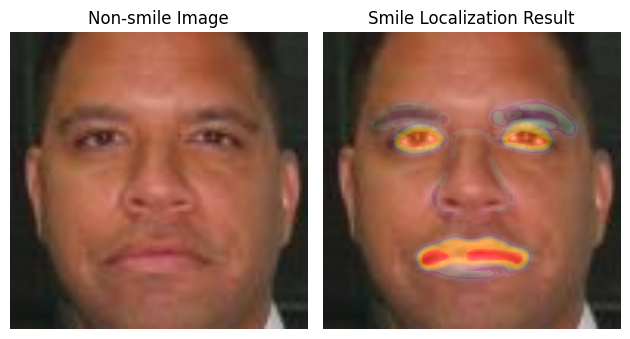

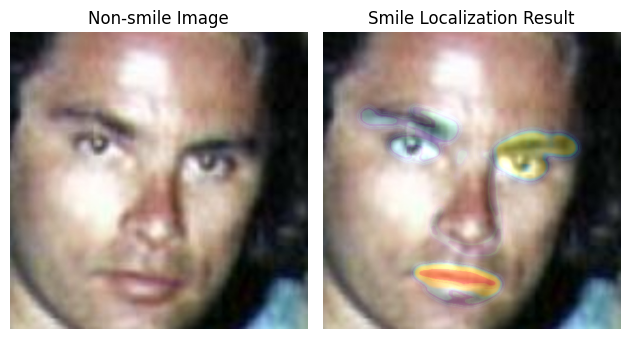

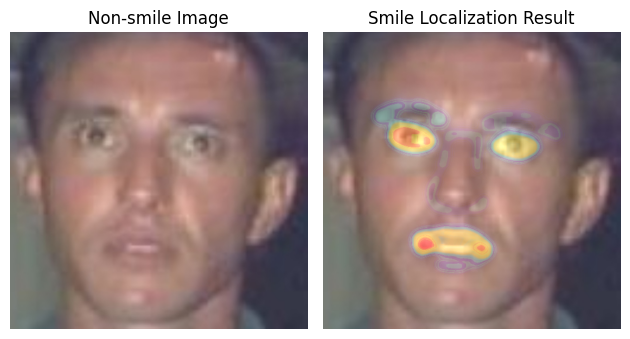

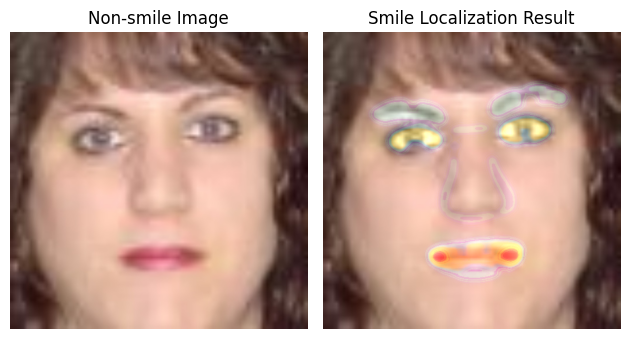

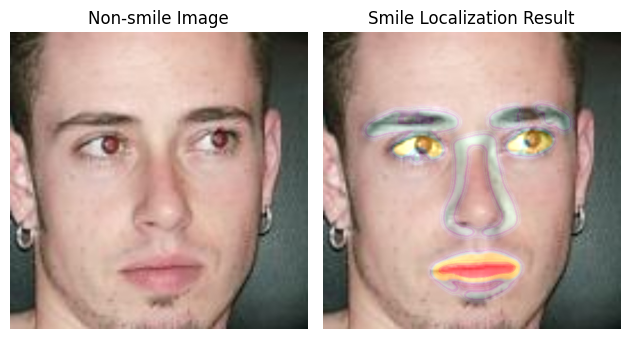

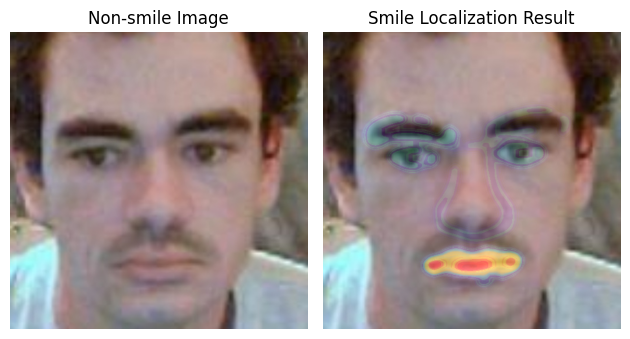

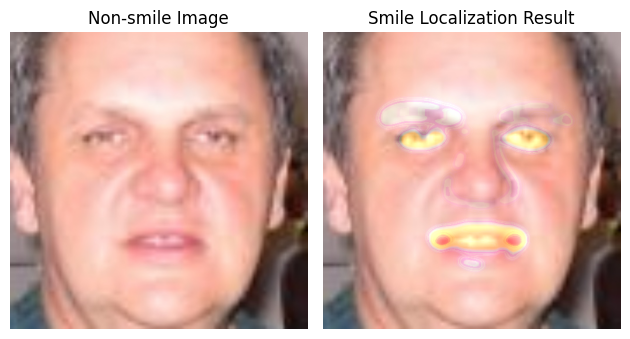

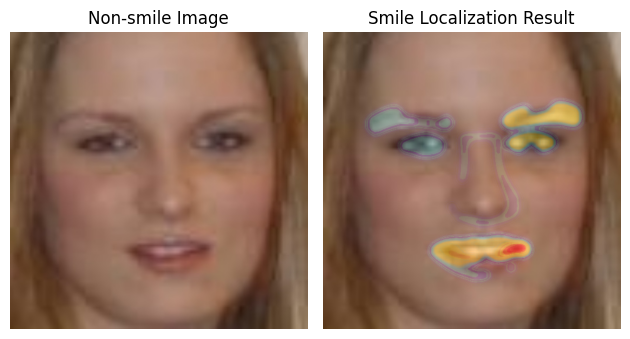

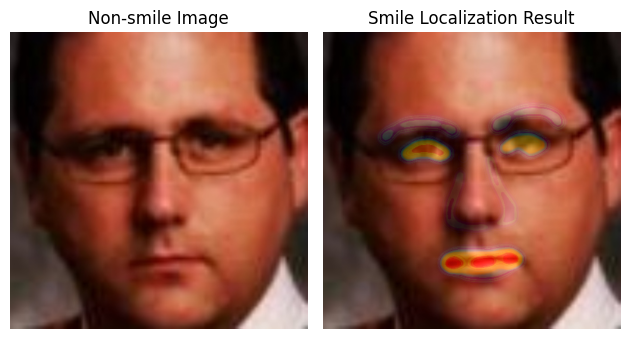

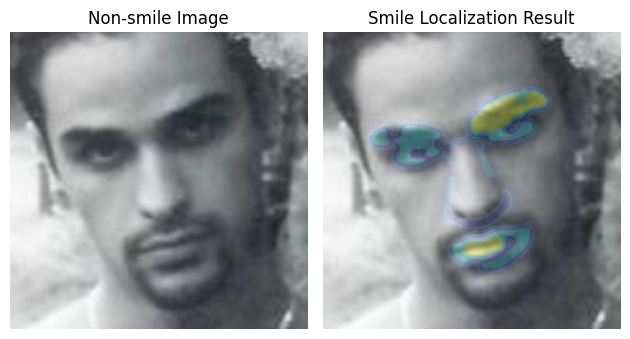

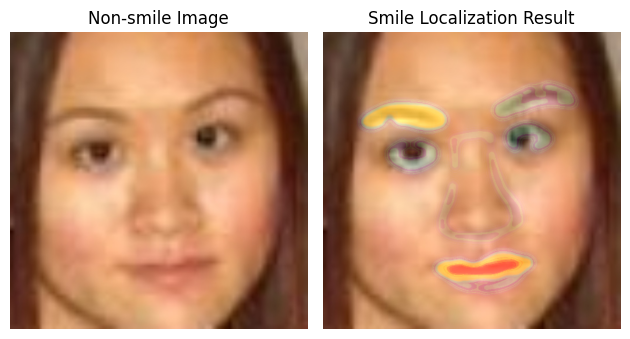

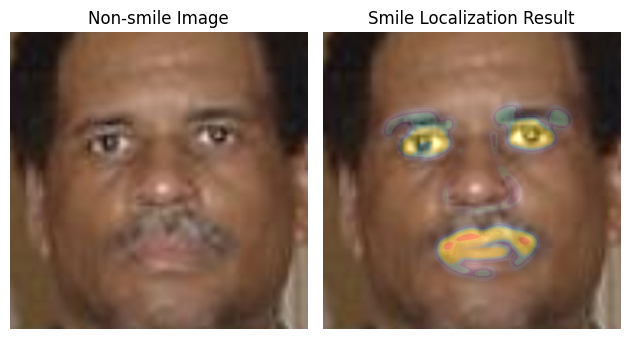

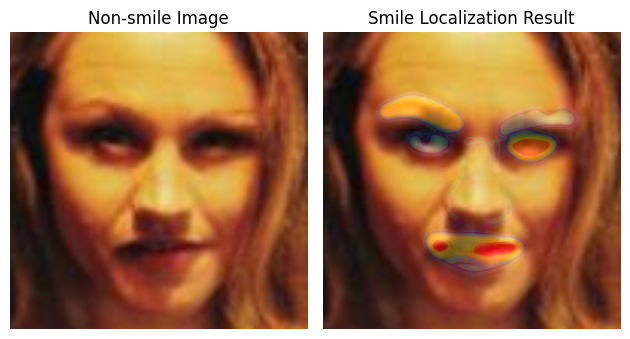

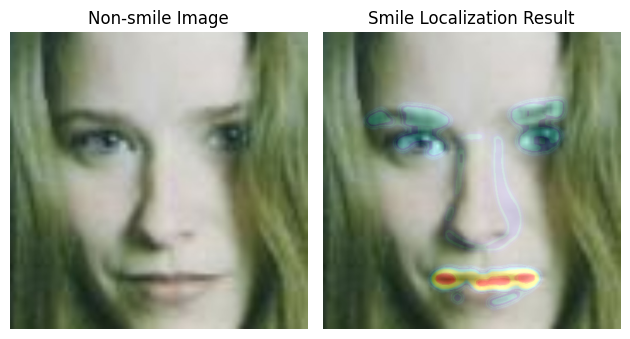

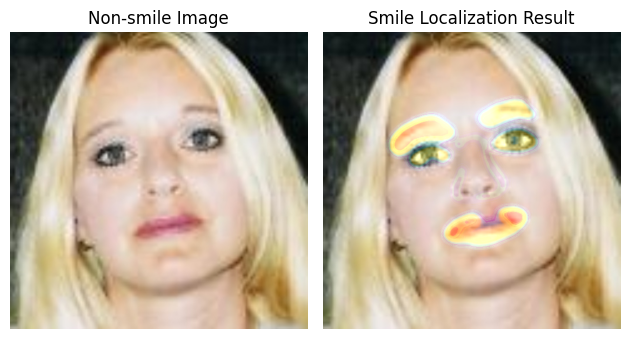

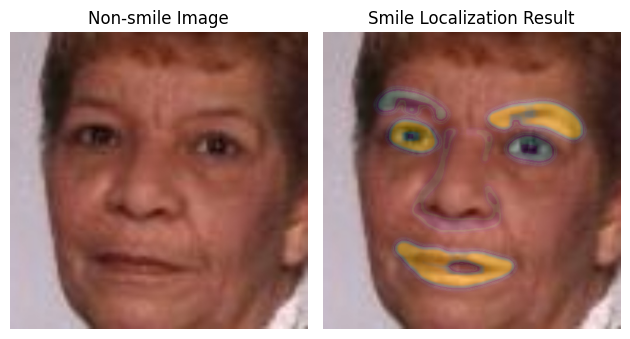

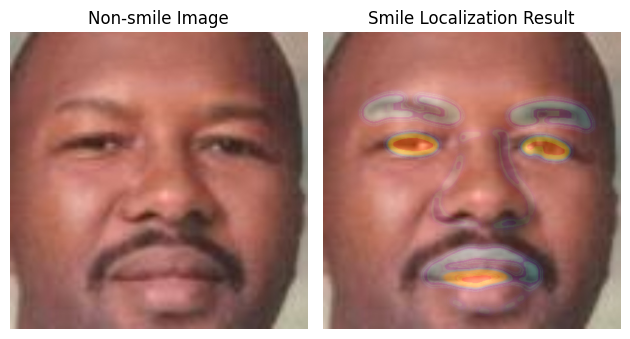

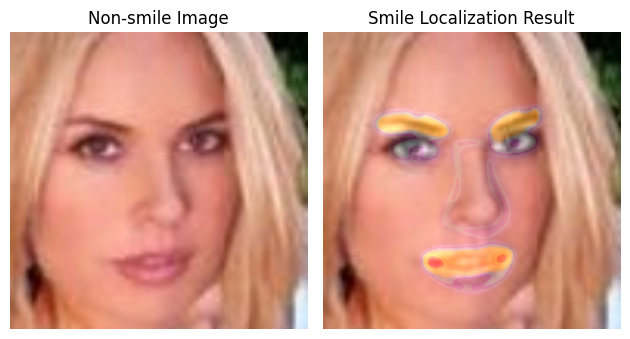

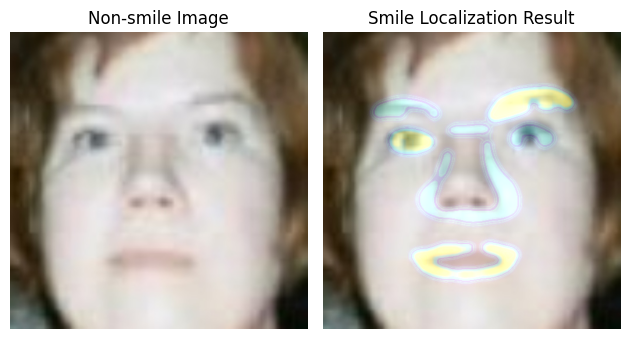

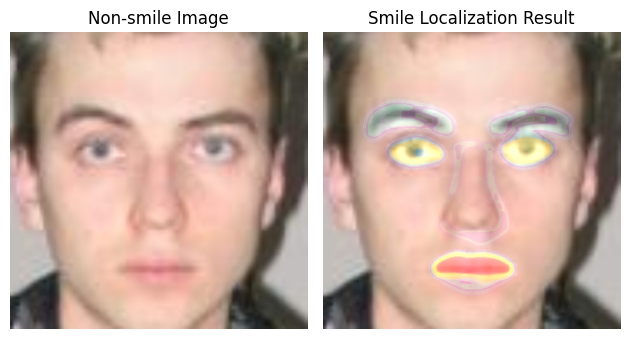

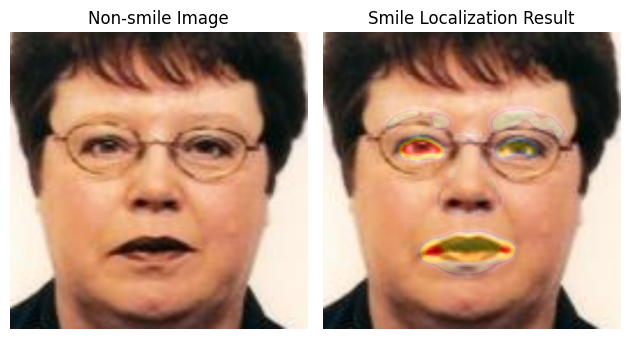

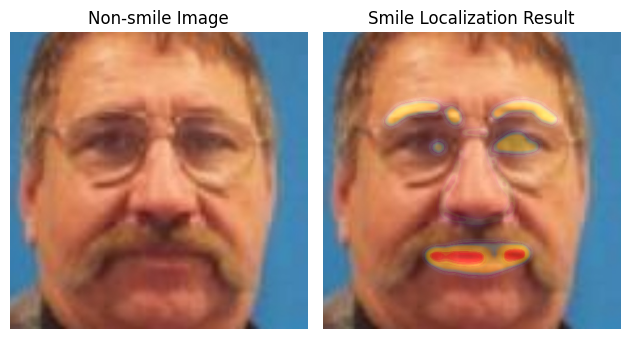

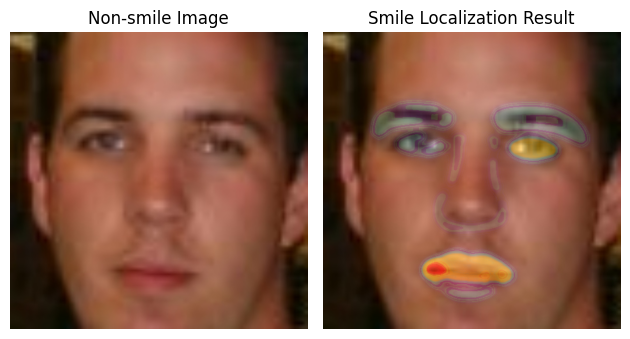

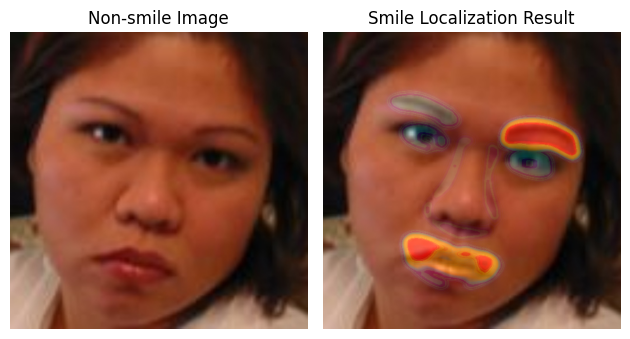

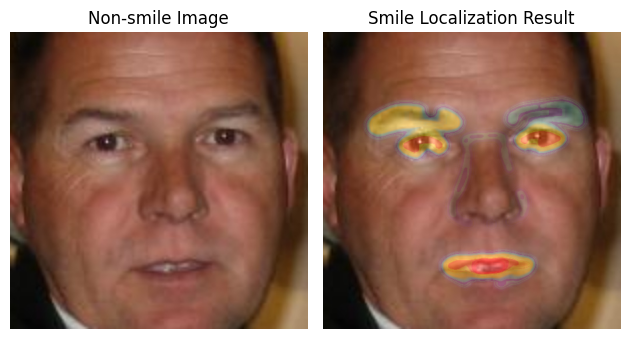

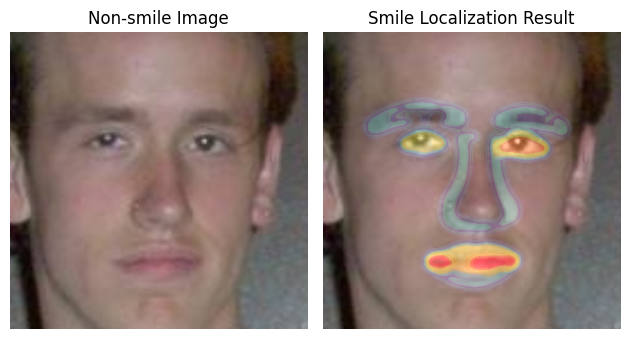

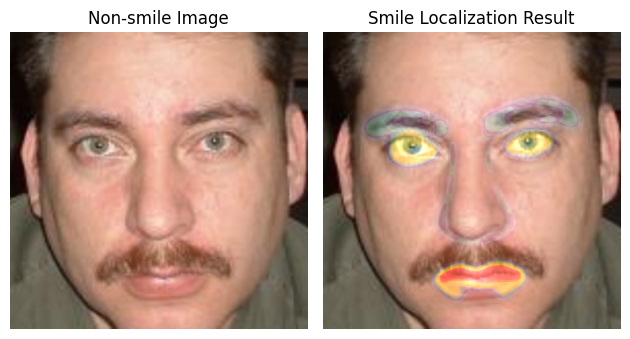

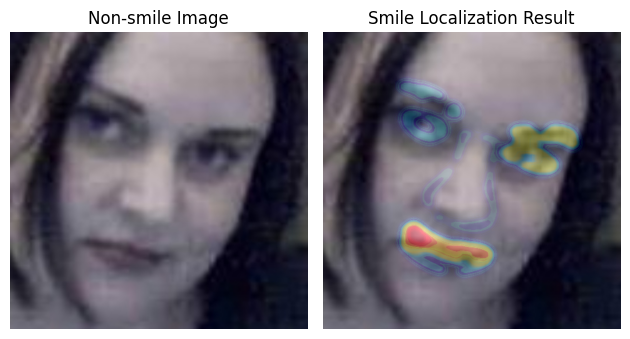

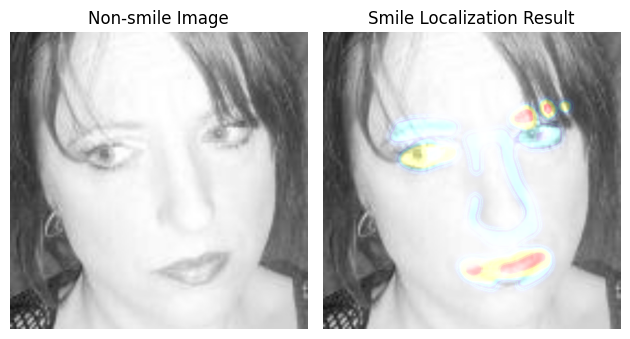

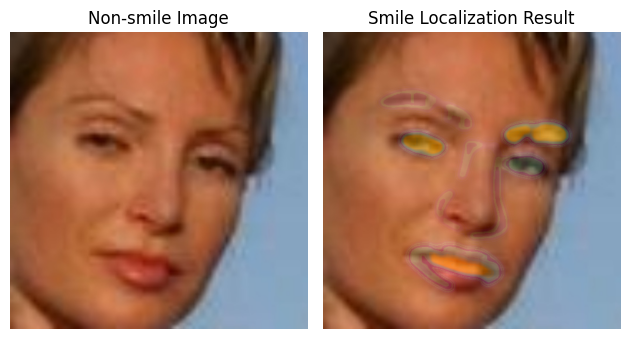

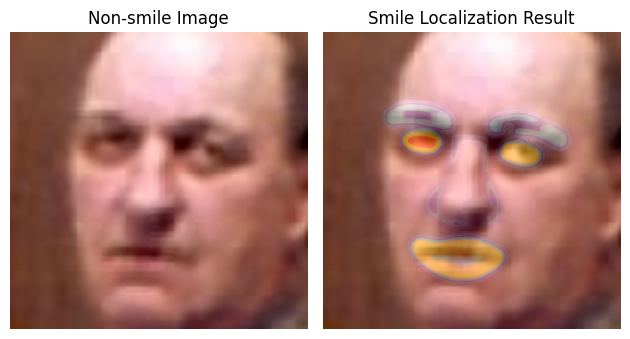

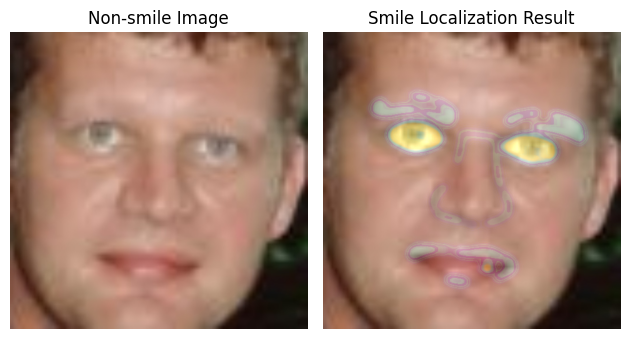

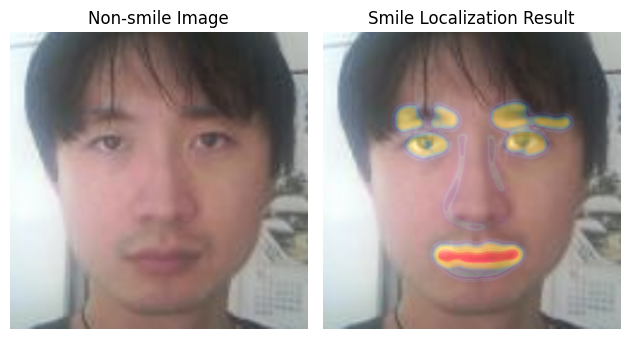

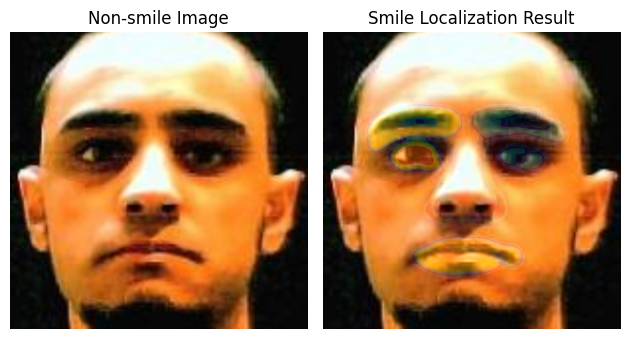

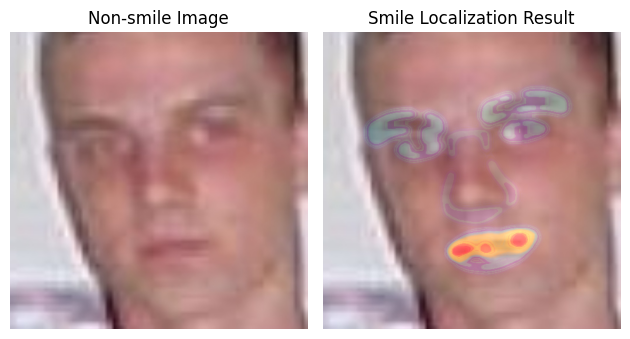

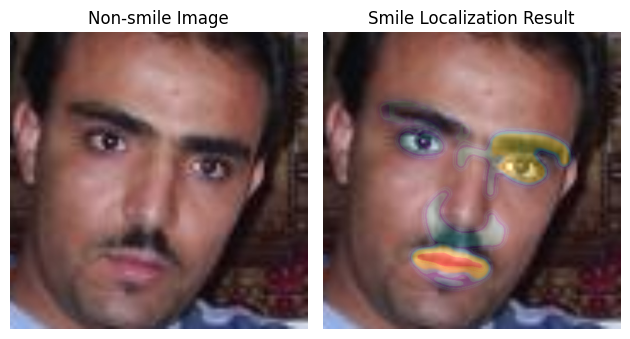

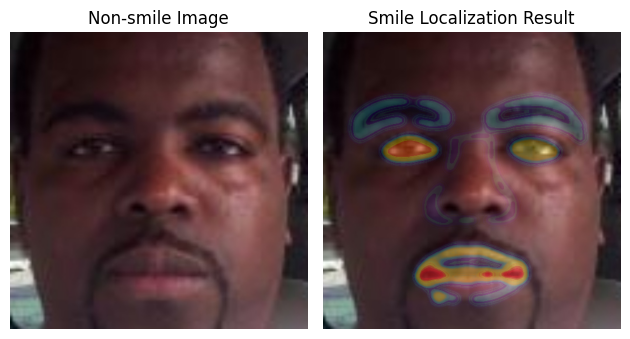

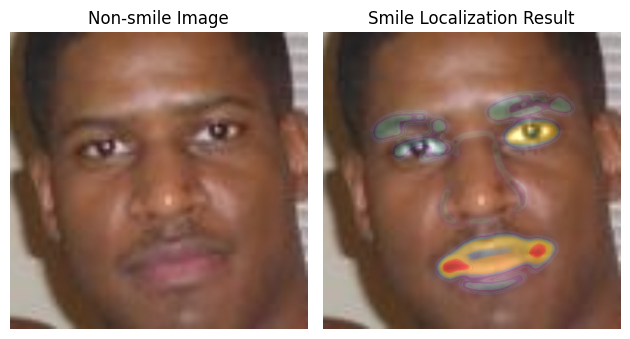

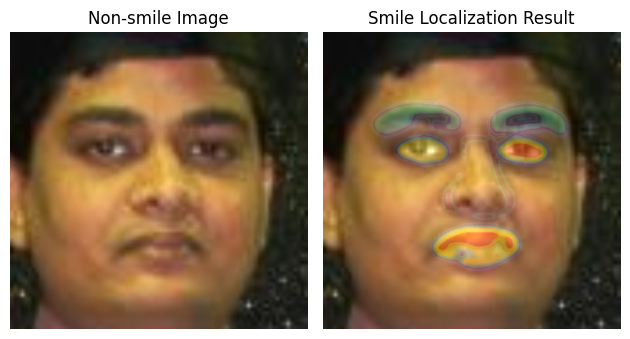

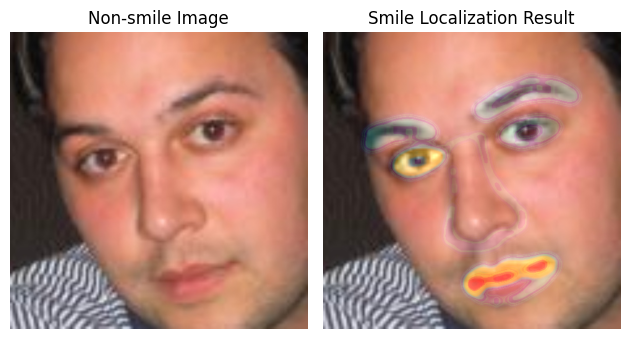

In [ ]:
img_path = "./Datasets/GENKI-4K_BIG/non_smile/images"
mask_path = './Datasets/GENKI-4K_BIG/non_smile/labels'

for name, label in zip(nonsmile_names, nonsmile_masks) :
    if name in list(file_list) :
        f_name = name.split('.')[0].split('_')[1]
        img = cv2.imread(os.path.join(img_path, f_name+'.jpg'))
        img = cv2.resize(img, (512,512), interpolation=cv2.INTER_LINEAR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        pred, iou_scores = cas.select_and_score_one_image(np.expand_dims(label, axis=0),
                                                          target_labels=range(1,9), mode='iou')
        # iou score 순위 정렬
        iou_scores_with_label = [(l+1, s) for l, s in enumerate(iou_scores)]
        sorted_ious = sorted(iou_scores_with_label, key=lambda s:s[1])

        cls2clb_label = label_changing(label.numpy().astype("uint8"), mode="class2celeb")
        cls2clb_pred = label_changing(pred.numpy().astype("uint8"), mode="class2celeb")

        label_face = cv2.imread(os.path.join(mask_path, 'face_'+f_name+'.png'))
        label_all = cv2.imread(os.path.join(mask_path, 'all_'+f_name+'.png'))
        label_face_copy = copy.deepcopy(label_face)
        label_all_copy = copy.deepcopy(label_all)

        label_face_color = mask_coloring(label_face_copy)
        label_all_color = mask_coloring(label_all, 'all')

        pred_all = attach_face_comp(img, label_face_color, label_all, cls2clb_pred)

        pred_face = get_comp_2(pred_all)

        f_label = copy.deepcopy(label_face)
        f_pred = copy.deepcopy(pred_face)
        f_label = label_changing(f_label, mode="celeb2class")
        f_pred = label_changing(f_pred, mode="celeb2class")


        # iou 작은 순으로 크게 component 별 가중치 주기
        weighted_label = np.zeros_like(f_label)
        weighted_pred = np.zeros_like(f_pred)

        for w, (l_num, score) in enumerate(sorted_ious) :
            weighted_label = weight_2(8-w, l_num, score, weighted_label, f_label)
            weighted_pred = weight_2(8-w, l_num, score, weighted_pred, f_pred)

        # binary mask로 차이 계산
        mask_diff, erosion1, erosion2 = subtraction(weighted_label, weighted_pred)
        diff, thresh, blur, heatmap_img, heat_overlay_img = heatmap_overlay_2(weighted_label, weighted_pred, img)

        col = 2
        plt.subplot(1, col, 1)
        plt.title('Non-smile Image')
        plt.imshow(img)
        plt.axis("off")

        plt.subplot(1, col, 2)
        plt.title('Smile Localization Result')
        plt.imshow(heat_overlay_img)
        plt.axis("off")
        plt.tight_layout()

        plt.savefig(os.path.join('./smile_localization/survey_img_ver3/VAE', '{}.png'.format(f_name)), transparent=True)

    plt.show()